In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random
import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [6]:

from gensim.models import Word2Vec

def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])   # tokenized sentence
        labels.append(item['ner_tags'])    # corresponding labels
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Train Word2Vec on the training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Build vocabulary and embedding matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))


In [7]:
# Prepare input sequences and pad
MAX_LEN = 256
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [8]:
torch.set_float32_matmul_precision("high")

In [9]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x

In [10]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

import torch.nn.functional as F

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        accuracies = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            mask = (y != 0)
            correct = (preds == y) & mask
            accuracy = correct.sum().item() / mask.sum().item()
            accuracies[k] = accuracy
        
        out[name] = {
            "loss": losses.mean().item(),
            "accuracy": accuracies.mean().item()
        }
    model.train()
    return out

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_model(model, optimizer): 
    model.to(device)
    max_iters = 2000
    eval_interval = 200
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    eval_steps = []

    lossi = []

    for step in range(max_iters):
        if step % eval_interval == 0:
            metrics = estimate_loss(model)
            
            train_losses.append(metrics['train']['loss'])
            test_losses.append(metrics['test']['loss'])
            train_accuracies.append(metrics['train']['accuracy'])
            test_accuracies.append(metrics['test']['accuracy'])
            eval_steps.append(step)

            print(
                f"Step {step}: "
                f"Train loss {metrics['train']['loss']:.4f}, accuracy {metrics['train']['accuracy']:.4f} | "
                f"Test loss {metrics['test']['loss']:.4f}, accuracy {metrics['test']['accuracy']:.4f}"
            )
        
        xb, yb = get_batch(train_dataset, batch_size)
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
        
        lossi.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_steps, train_losses, label="Train Loss")
    plt.plot(eval_steps, test_losses, label="Test Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, train_accuracies, label="Train Accuracy")
    plt.plot(eval_steps, test_accuracies, label="Test Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [12]:
def evaluate_model(model):
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()
    
    true_labels = y_test.cpu().numpy()
    
    # Format for evaluation
    true_str = []
    pred_str = []
    for t_seq, p_seq in zip(true_labels, pred_labels):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != 0:
                temp_true.append(labels[t])
                temp_pred.append(labels[p])
        true_str.append(temp_true)
        pred_str.append(temp_pred)
    
    # Detailed evaluation report
    print("Classification Report:\n")
    print(classification_report(true_str, pred_str))
    print("F1 Score:", f1_score(true_str, pred_str))
    print("Accuracy:", accuracy_score(true_str, pred_str))

    flat_true = [ltoi[l] for seq in true_str for l in seq]
    flat_pred = [ltoi[l] for seq in pred_str for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Step 0: Train loss 1.3840, accuracy 0.2048 | Test loss 1.3832, accuracy 0.2275
Step 200: Train loss 0.4900, accuracy 0.8151 | Test loss 0.4981, accuracy 0.8036
Step 400: Train loss 0.2590, accuracy 0.9146 | Test loss 0.3181, accuracy 0.8883
Step 600: Train loss 0.1062, accuracy 0.9683 | Test loss 0.2896, accuracy 0.8921
Step 800: Train loss 0.0450, accuracy 0.9891 | Test loss 0.4027, accuracy 0.8662
Step 1000: Train loss 0.0201, accuracy 0.9963 | Test loss 0.3925, accuracy 0.8677
Step 1200: Train loss 0.0095, accuracy 0.9993 | Test loss 0.4386, accuracy 0.8542
Step 1400: Train loss 0.0055, accuracy 0.9997 | Test loss 0.3879, accuracy 0.8671
Step 1600: Train loss 0.0038, accuracy 1.0000 | Test loss 0.5130, accuracy 0.8523
Step 1800: Train loss 0.0026, accuracy 1.0000 | Test loss 0.5394, accuracy 0.8503


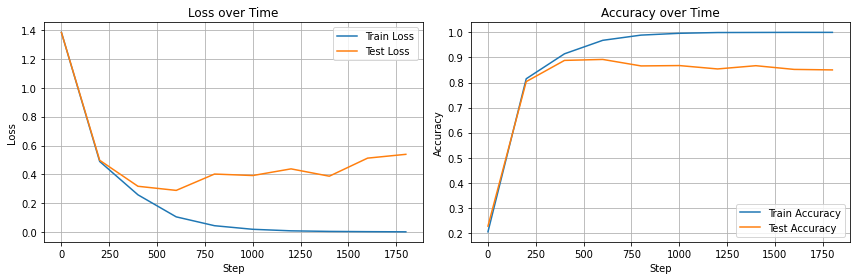

Classification Report:

              precision    recall  f1-score   support

          AC       0.85      0.84      0.84       797
          LF       0.58      0.72      0.64       482

   micro avg       0.73      0.79      0.76      1279
   macro avg       0.71      0.78      0.74      1279
weighted avg       0.75      0.79      0.77      1279

F1 Score: 0.760119940029985
Accuracy: 0.8527533918595371


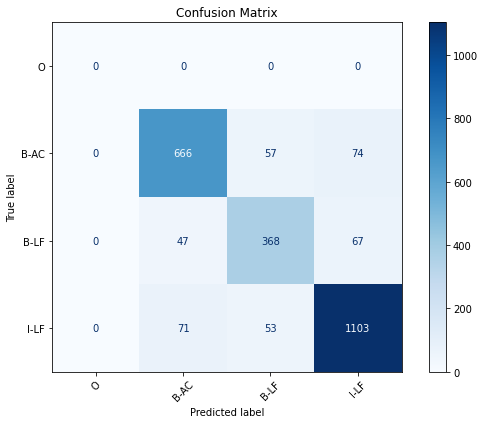

In [13]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3597, accuracy 0.3291 | Test loss 1.3602, accuracy 0.3160
Step 200: Train loss 0.7400, accuracy 0.7263 | Test loss 0.7194, accuracy 0.7297
Step 400: Train loss 0.5845, accuracy 0.7695 | Test loss 0.5631, accuracy 0.7856
Step 600: Train loss 0.4223, accuracy 0.8444 | Test loss 0.4754, accuracy 0.8308
Step 800: Train loss 0.3173, accuracy 0.8913 | Test loss 0.4694, accuracy 0.8244
Step 1000: Train loss 0.2423, accuracy 0.9172 | Test loss 0.5417, accuracy 0.7846
Step 1200: Train loss 0.1907, accuracy 0.9427 | Test loss 0.5388, accuracy 0.7928
Step 1400: Train loss 0.1225, accuracy 0.9689 | Test loss 0.5379, accuracy 0.7952
Step 1600: Train loss 0.0882, accuracy 0.9774 | Test loss 0.9987, accuracy 0.6754
Step 1800: Train loss 0.0721, accuracy 0.9810 | Test loss 0.9558, accuracy 0.7030


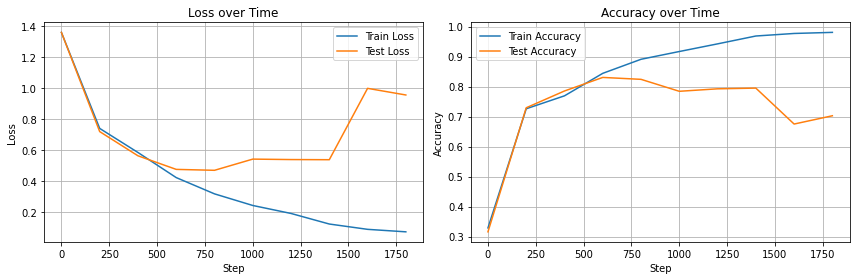

Classification Report:

              precision    recall  f1-score   support

          AC       0.53      0.96      0.68       797
          LF       0.56      0.46      0.50       482

   micro avg       0.53      0.77      0.63      1279
   macro avg       0.54      0.71      0.59      1279
weighted avg       0.54      0.77      0.61      1279

F1 Score: 0.6313437599744653
Accuracy: 0.689146049481245


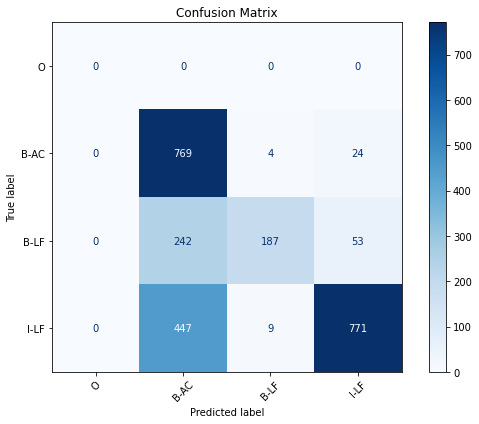

In [14]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3821, accuracy 0.2145 | Test loss 1.3834, accuracy 0.2088
Step 200: Train loss 1.2790, accuracy 0.4769 | Test loss 1.2756, accuracy 0.4931
Step 400: Train loss 1.2251, accuracy 0.4490 | Test loss 1.2025, accuracy 0.5027
Step 600: Train loss 1.1732, accuracy 0.4786 | Test loss 1.1685, accuracy 0.4804
Step 800: Train loss 1.1460, accuracy 0.4648 | Test loss 1.1464, accuracy 0.4674
Step 1000: Train loss 1.1198, accuracy 0.4702 | Test loss 1.1152, accuracy 0.4829
Step 1200: Train loss 1.0997, accuracy 0.4766 | Test loss 1.0980, accuracy 0.4891
Step 1400: Train loss 1.0849, accuracy 0.4752 | Test loss 1.0791, accuracy 0.4942
Step 1600: Train loss 1.0911, accuracy 0.4455 | Test loss 1.0783, accuracy 0.4755
Step 1800: Train loss 1.0796, accuracy 0.4531 | Test loss 1.0586, accuracy 0.4888


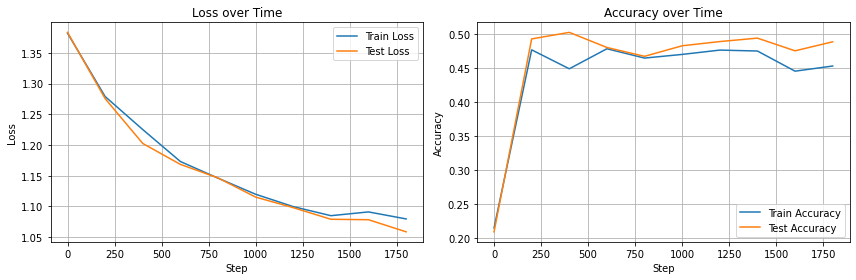

Classification Report:

              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       797
          LF       0.00      0.00      0.00       482

   micro avg       0.00      0.00      0.00      1279
   macro avg       0.00      0.00      0.00      1279
weighted avg       0.00      0.00      0.00      1279

F1 Score: 0.0013080444735120993
Accuracy: 0.4896249002394254


/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


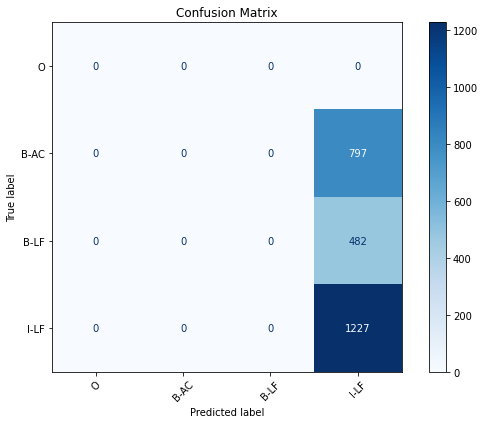

In [15]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0003)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.4057, accuracy 0.2139 | Test loss 1.4152, accuracy 0.1570
Step 200: Train loss 0.6780, accuracy 0.7576 | Test loss 0.6512, accuracy 0.7571
Step 400: Train loss 0.5795, accuracy 0.7766 | Test loss 0.5401, accuracy 0.7971
Step 600: Train loss 0.5091, accuracy 0.8122 | Test loss 0.5266, accuracy 0.7886
Step 800: Train loss 0.4837, accuracy 0.8159 | Test loss 0.4699, accuracy 0.8154
Step 1000: Train loss 0.4019, accuracy 0.8527 | Test loss 0.4481, accuracy 0.8307
Step 1200: Train loss 0.3459, accuracy 0.8738 | Test loss 0.4083, accuracy 0.8490
Step 1400: Train loss 0.3223, accuracy 0.8799 | Test loss 0.3801, accuracy 0.8602
Step 1600: Train loss 0.3106, accuracy 0.8869 | Test loss 0.3311, accuracy 0.8795
Step 1800: Train loss 0.2910, accuracy 0.8980 | Test loss 0.2977, accuracy 0.8879


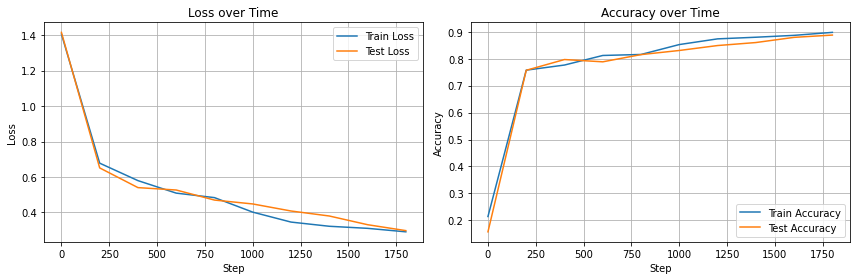

Classification Report:

              precision    recall  f1-score   support

          AC       0.90      0.91      0.90       797
          LF       0.72      0.85      0.78       482

   micro avg       0.83      0.89      0.86      1279
   macro avg       0.81      0.88      0.84      1279
weighted avg       0.83      0.89      0.86      1279

F1 Score: 0.8553078957310163
Accuracy: 0.8910614525139665


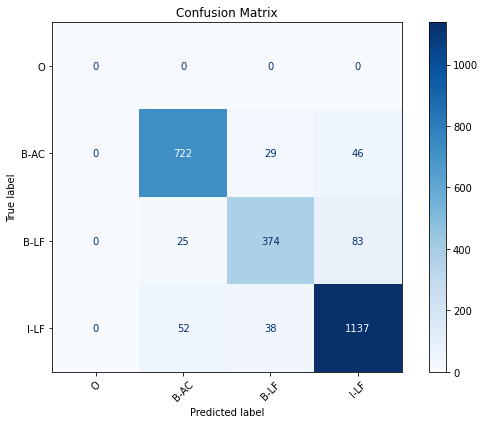

In [16]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)